In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback, EarlyStopping

In [2]:
df = pd.read_parquet("cleaned.parquet")
df

,lyric_clean
0,he said the way my blue eyes shined
1,put those georgia stars to shame that night
2,i said that is a lie
3,just a boy in a chevy truck
4,that had a tendency of gettin' stuck
...,...
5310,even when i lose my mind
5311,i need to say
5312,tell me that it is not my fault
5313,tell me that i am all you want


## Using LSTM for Lyric Generation

In this project, I'm going to use LSTM (Long Short-Term Memory) networks for generating lyrics in the style of Taylor Swift.

### What is an LSTM?

LSTMs are a special kind of neural network that excel in learning from sequences, like sentences in a song. What LSTMs do with data—they remember not just the immediate past but also information from way back.

### How We Prepare Training Data and Labels

1. **Tokenization**: First, we convert the lyrics into a format that our LSTM model can understand. We do this by breaking down the lyrics into individual words and then converting each word into a unique number. This process is known as tokenization.

2. **Creating Input Sequences**: We then create sequences of these numbers. Each sequence is a part of a lyric line, and with each step, we add one word to the sequence. This way, the model learns to predict the next word in a sequence.

3. **Padding**: Since not all sequences are of the same length, we make them uniform by adding zeroes to the shorter sequences, a process known as padding.

4. **Splitting the Data**: The sequences are then divided into two parts: predictors and the label. The predictors are the sequences of numbers we input into the model, and the label is the next number that the model needs to predict.

5. **One-Hot Encoding**: Finally, we convert labels into a format where all possibilities are represented as zeroes, except the actual label, which is represented as a one.

6. **Train-Test Split**: Lastly, we split our dataset into a training set and a validation set. The training set is used to train the model, while the validation set is used to test its performance and accuracy.


In [4]:
combined_lyrics = ' '.join(df['lyric_clean'])
tokenizer = Tokenizer()
tokenizer.fit_on_texts([combined_lyrics])
total_words = len(tokenizer.word_index) + 1
input_sequences = []
for line in df['lyric_clean']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_len = max(len(x) for x in input_sequences)
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
predictors, label = input_sequences[:,:-1], input_sequences[:,-1]
label = to_categorical(label, num_classes=total_words)

# Splitting Data
X_train, X_val, y_train, y_val = train_test_split(predictors, label, test_size=0.2, random_state=42)

In [5]:
X_train

array([[   0,    0,    0, ...,    5,    6,   19],
       [   0,    0,    0, ...,   33,    2,   16],
       [   0,    0,    0, ...,    0,    0,    1],
       ...,
       [   0,    0,    0, ...,    0,   55,    3],
       [   0,    0,    0, ...,   19,    9, 1012],
       [   0,    0,    0, ...,    0,    0,   37]], dtype=int32)

In [6]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [10]:
# Perplexity Calculation
class Perplexity(Callback):
    def on_epoch_end(self, epoch, logs={}):
        cross_entropy = logs.get('loss')
        perplexity = np.exp(cross_entropy)
        print(f' - perplexity: {perplexity}')

def viz_metrics(history):
    # Visualizing Training and Validation Metrics
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

def train(model):
  earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto', restore_best_weights=True)
  history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[earlystop, Perplexity()])
  return history

def generate(model, seed_text):
  next_words = 100  # Number of words you want to generate

  for _ in range(next_words):
      # Tokenize the current seed text
      token_list = tokenizer.texts_to_sequences([seed_text])[0]

      # Pad the sequence
      token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

      # Predict the next word (as probabilities)
      probabilities = model.predict(token_list, verbose=0)

      # Get the index of the most likely next word
      predicted = np.argmax(probabilities, axis=-1)[0]

      # Convert the predicted token to a word
      output_word = ""
      for word, index in tokenizer.word_index.items():
          if index == predicted:
              output_word = word
              break

      # Update the seed text
      seed_text += " " + output_word

  return seed_text


def sample_with_temperature(probabilities, temperature=1.0):
    # Adjust the probabilities with temperature
    probabilities = np.asarray(probabilities).astype('float64')
    probabilities = np.log(probabilities + 1e-10) / temperature  # Adding a small constant to avoid division by zero
    exp_probs = np.exp(probabilities)
    probabilities = exp_probs / np.sum(exp_probs)

    # Sample the next word based on the adjusted probabilities
    choices = range(len(probabilities))
    next_word = np.random.choice(choices, p=probabilities)

    return next_word

def generate_with_temperature(model, seed_text, temperature=1.0):

    next_words = 100
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

        probabilities = model.predict(token_list, verbose=0)[0]

        # Use temperature to adjust the probabilities and sample the next word
        predicted = sample_with_temperature(probabilities, temperature=temperature)

        # Convert the predicted token to a word and update the seed text
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word

    return seed_text


## Baseline model


### Model Architecture

1. **Input Layer (Embedding Layer)**:
   - `Embedding`: The first layer is an Embedding layer, which is used to convert our input data into dense vectors of fixed size. Here, `total_words` is the size of the vocabulary, and `100` is the dimensionality of the embedding vectors. The `input_length` is set to `max_sequence_len - 1`, which is the length of the input sequences.

2. **LSTM Layer**:
   - `LSTM`: After the Embedding layer, we have an LSTM layer with 150 units. This layer will process the sequence of word embeddings output by the previous layer.

3. **Output Layer (Dense Layer)**:
   - `Dense`: The final layer is a Dense layer with a softmax activation function. The size of this layer is equal to `total_words`, which represents the total number of unique words in the vocabulary. The softmax activation function will output a probability distribution over the vocabulary for the next word in the sequence.

The loss function used is `categorical_crossentropy`, which is suitable for multi-class classification problems. We use the `adam` optimizer, which is an algorithm for first-order gradient-based optimization of stochastic objective functions. The metrics we are interested in monitoring is `accuracy`.

### Early Stopping

- `EarlyStopping`: EarlyStopping is a callback that stops the training process when a monitored metric has stopped improving. We are monitoring the validation loss (`val_loss`), and if the loss does not decrease (`min_delta=0`) for three epochs (`patience=3`), the training will stop. The `verbose=1` setting allows us to see the output of the early stopping events. The `mode='auto'` will determine the direction of improvement automatically and `restore_best_weights=True` ensures that the model's weights will revert to those that yielded the lowest validation loss.

If the `val_loss` begins to increase as training proceeds, it can be an indicator of overfitting.

### Training the Model

- The model will train for a maximum of 100 epochs on the training data `X_train` and `y_train`.

- During training, the model's performance is also validated using a separate validation set.

-  `Perplexity()` is  a custom callback (not provided in the standard Keras callbacks) which likely computes the perplexity metric after each epoch, a common evaluation metric in language modeling. A lower perplexity score indicates better predictive performance, as it means the model is more certain about its predictions.



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 22, 100)           357300    
                                                                 
 lstm_2 (LSTM)               (None, 150)               150600    
                                                                 
 dense_2 (Dense)             (None, 3573)              539523    
                                                                 
Total params: 1047423 (4.00 MB)
Trainable params: 1047423 (4.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
882/882 [==============================] - 16s 16ms/step - loss: 6.0935 - accuracy: 0.0501 - val_loss: 5.8416 - val_accuracy: 0.0705
Epoch 2/100
882/882 [==============================] - 7s 8ms/step - loss: 5.4265 - accuracy: 0.1064 - val_loss: 5.4597 - val_accuracy:

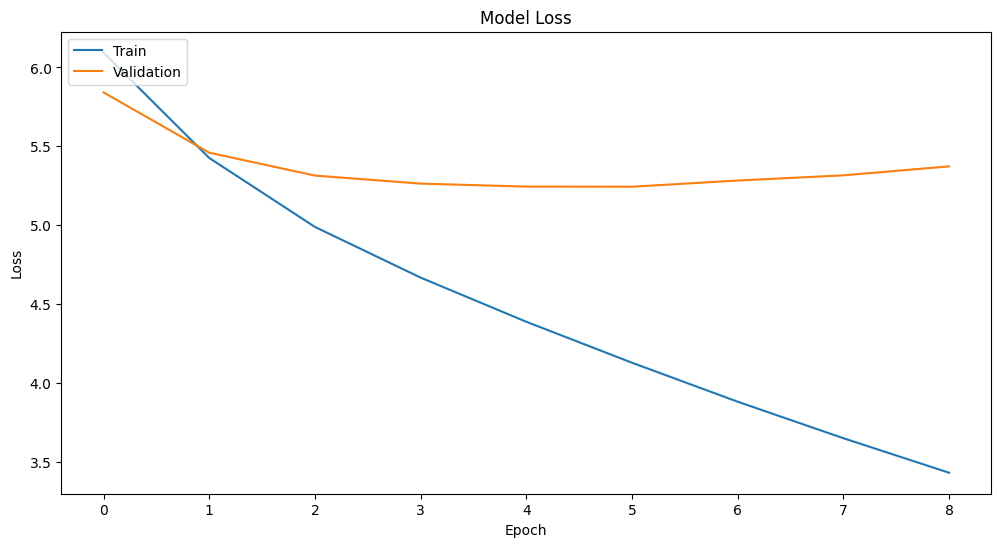

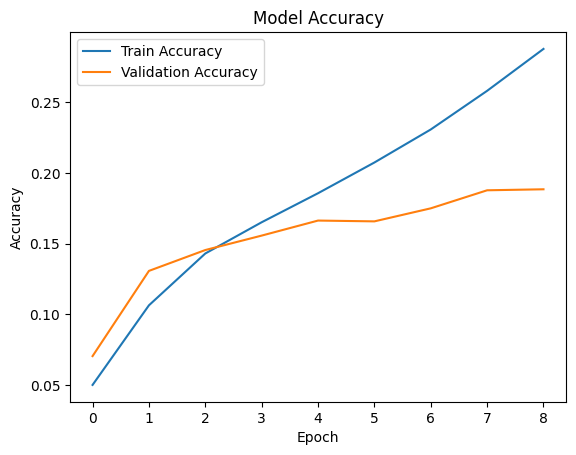

In [19]:
# Building the Model
baseline_model = Sequential()
baseline_model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
baseline_model.add(LSTM(150))
baseline_model.add(Dense(total_words, activation='softmax'))
baseline_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

baseline_model.summary()

history = train(baseline_model)
viz_metrics(history)

For generative models, such as those used in text generation, the objective is often to produce text that is coherent and contextually relevant, rather than to maximize the next-word prediction accuracy. A model could have lower accuracy but still generate high-quality, diverse text. This is because it may learn to produce text that follows the style and structure of the language, even though it doesn't always guess the exact word that appears in the training set.


### How Do We Generate Text?

1. **Starting with the Seed**: We begin with the seed text and prepare it for prediction. This involves tokenizing the text (converting words to numerical values) and padding it to ensure it fits the model's expected input shape.

2. **Word-by-Word Generation**:
   - The model predicts the next word based on the current seed text, one word at a time.
   - It outputs a probability distribution over the entire vocabulary for the next word.
   - The word corresponding to the highest probability (the most likely next word) is chosen and added to the seed text.

3. **Updating the Seed Text**:
   - After each prediction, the seed text is updated to include the new word.
   - This updated seed text is then fed back into the model for the next round of prediction.

4. **Repeating the Process**:
   - This loop continues for a set number of iterations (e.g., 100 words in our case).


In [20]:
generate(baseline_model, 'ring any bells')

'ring any bells that i am not a girl to know that i am not a girl to know that i am not a girl to know that i am not a girl to know that i am not a girl to know that i am not a girl to know that i am not a girl to know that i am not a girl to know that i am not a girl to know that i am not a girl to know that i am not a girl to know that i am not a girl to know that i am not'

### Generating with Temperature (Sampling Softly):

- **Temperature**: When generating text, we can use a concept known as "temperature" to influence the randomness of predictions.
   - A high temperature results in more random predictions (more creative or surprising text).
   - A low temperature leads to more predictable predictions (often more repetitive text).
- The `sample_with_temperature` function adjusts the model's predicted probabilities before sampling the next word, allowing us to control the "creativity" of the generated text.


In [21]:
generate_with_temperature(baseline_model, 'ring any bells', 0.6)

'ring any bells and a time that is not a world where you would be the one girl yeah that i am a new thing that i could not go back to december on the day you all while so yeah oh yeah you should have been gone by me to be this girl well yeah yeah yeah yeah yeah yeah yeah i saw you around and halls pauses yeah oh oh yeah preacher say i could not be off you oh oh yeah oh oh yeah i will be the one of my way to the shiniest uh way the list of'

In [26]:
generate_with_temperature(baseline_model, 'ring any bells', 0.2)

'ring any bells that i am not a girl to know it is a bad time i am not a girl to know it is not a girl but i am not you and i am not you and i am not you to the girl to me for me to me up me to be the way you to be the way to me yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah i am not you and i am not you around to the way you are the one of me'

**No Temperature (Default Behavior):**

The first generated text, without any temperature adjustment, shows a high level of repetition. This is a common characteristic of LSTM models when they become too confident about the next word, leading to a loop of repeated words or phrases.

**Temperature Setting: 0.6:**

With a temperature of 0.6, the generated text shows more variety and less repetition. The sentences appear more diverse and less predictable than in the no-temperature case. This indicates that a moderate temperature can encourage the model to explore a wider range of words while still maintaining a degree of coherence.

**Temperature Setting: 0.2:**

A lower temperature of 0.2 results in text that is somewhat repetitive but less so than the no-temperature case. It seems to strike a balance between repetition and randomness. The model is more conservative than at 0.6 but avoids getting stuck in as many repetitive loops.

## Exploring Different Architectures in LSTM Models

1. **Increasing Layer Complexity**:
   - I will experiment with adding more LSTM layers to our model. This approach, known as 'deepening' the model, can enhance its ability to capture and learn more complex patterns and relationships in the data.

3. **Variations in LSTM Layers**:
   - Adjusting the number of units in LSTM layers or employing bidirectional LSTMs (which process data in both forward and backward directions).

2. **Incorporating Regularization**:
   - Introducing layers like Dropout or Batch Normalization can aid in preventing overfitting.



### Model 1 Architecture

1. **Embedding Layer**

2. **First LSTM Layer with Return Sequences**: this LSTM layer has 150 units, but unlike the previous model,
it is configured with `return_sequences=True`. This setting allows the layer to return the full sequence of outputs to the next layer instead of just the output of the last time step.

3. **Dropout for Regularization (First Instance)**:
   - `Dropout(0.1)`: Following the first LSTM layer, we introduce a Dropout layer with a dropout rate of 0.1 (10%). Dropout is a regularization technique where randomly selected neurons are ignored during training, which helps in preventing overfitting.

4. **Second LSTM Layer**:
   - `LSTM(100)`: A second LSTM layer follows, this time with 100 units. This layer does not return the full sequences, but only the output of the last time step, which is suitable for feeding into the Dense output layer.

5. **Dropout for Regularization (Second Instance)**:
   - Another Dropout layer is added with the same rate of 0.1, further helping in the regularization process.

6. **Dense Output Layer**:
   - `Dense(total_words, activation='softmax')`: The final layer remains a Dense layer with a softmax activation function.


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 22, 100)           357300    
                                                                 
 lstm_5 (LSTM)               (None, 22, 150)           150600    
                                                                 
 dropout_2 (Dropout)         (None, 22, 150)           0         
                                                                 
 lstm_6 (LSTM)               (None, 100)               100400    
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 3573)              360873    
                                                                 
Total params: 969173 (3.70 MB)
Trainable params: 96917

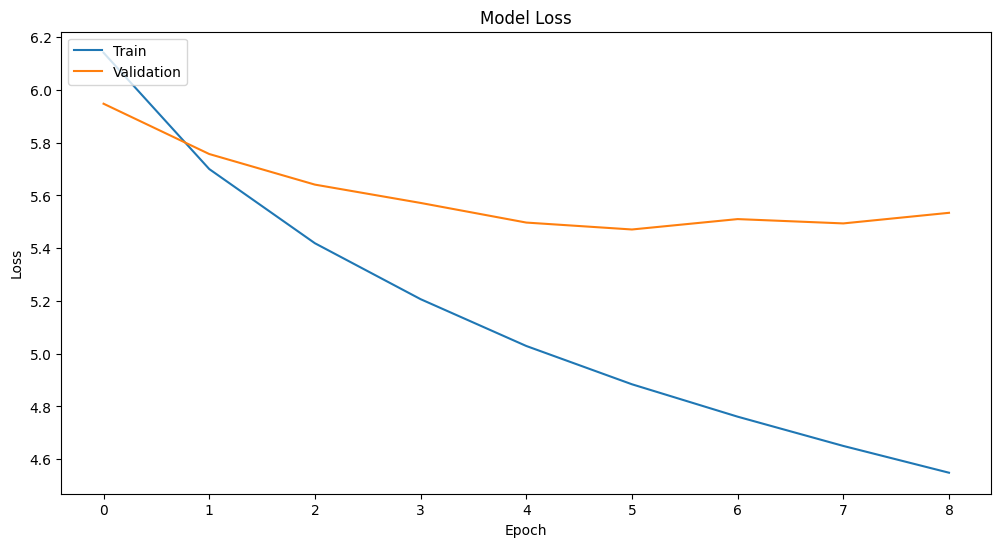

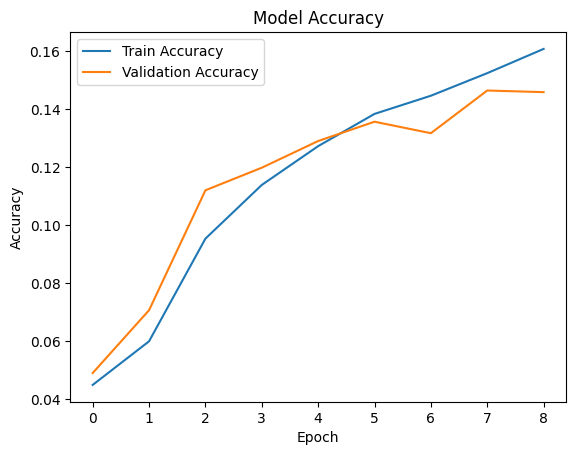

In [30]:
# Building the Model
model1 = Sequential()
model1.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model1.add(LSTM(150, return_sequences=True))
model1.add(Dropout(0.1))
model1.add(LSTM(100))
model1.add(Dropout(0.1))
model1.add(Dense(total_words, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model1.summary()

history = train(model1)
viz_metrics(history)

Accuracy and preplexity are lower than in the baseline model, let's look at generated text

In [31]:
print(generate(model1, 'ring any bells'))
print(generate_with_temperature(model1, 'ring any bells', 0.6))
print(generate_with_temperature(model1, 'ring any bells', 0.2))

ring any bells i am not the time of the time of the time of the time of the time of the storyline frustrating time notwant combat notwant combat i storyline frustrating the storyline frustrating time notwant combat you frustrating frustrating time notwant combat you are not the time of the storyline frustrating frustrating frustrating of the time of the time notwant the time of the storyline frustrating frustrating frustrating of combat notwant combat notwant combat notwant combat notwant the storyline frustrating time notwant combat you frustrating frustrating frustrating frustrating of the time of the time of the time of combat notwant the
ring any bells of your head around the time of my night of your town and i was not now we do madhouse remembering my weekends gleaming coastal finds commit on sleepers champion that precipice rock it is a my yet are and slow gate wrap flickers reading pounds me up to know it is that you are awful tupelo wrinkle patrn for the face and i do not know 

I asked ChatGPT to format generation with 0.6 as a song and that what I got:

Ring any bells of your head around,

The time of my night, in your town.

And I was not, now we do,

Madhouse remembering, my weekends too.

Gleaming coastal finds, commit on sleepers,

Champion that precipice, rock it deeper.

It is a my yet are and slow,

Gate wrap flickers, reading pounds me so.

Up to know it is, that you are awful,

Tupelo wrinkle, patrn for the soulful.

And I do not know, you will be,

The step on the little, kiss me to see.

Do not like me gone, and my sad uh,

Time of cancel, Tupelo, much too far.

A lot vision and you, letting a eyes,

Of the...


### Model 2 Architecture

Let's add some Biderectional levels.

The Bidirectional wrapper allows the LSTM to process the input sequence in both forward and backward directions, capturing patterns that may be missed when the sequence is processed in only one direction. The `return_sequences=True` parameter ensures that the output for each timestep is returned, making it suitable for connecting to subsequent recurrent layers.


## Embedding/Bidirectional LTSM/Dropout/Bidirectional LTSM/Dense

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 22, 100)           357300    
                                                                 
 bidirectional (Bidirection  (None, 22, 500)           702000    
 al)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 22, 500)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 300)               781200    
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 3573)              1075473   
                                                                 
Total params: 2915973 (11.12 MB)
Trainable params: 291

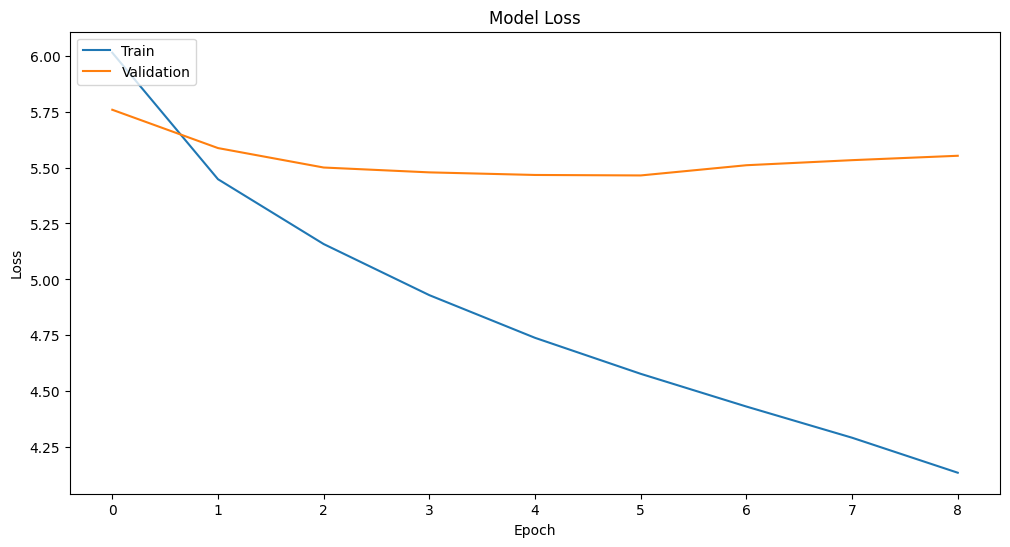

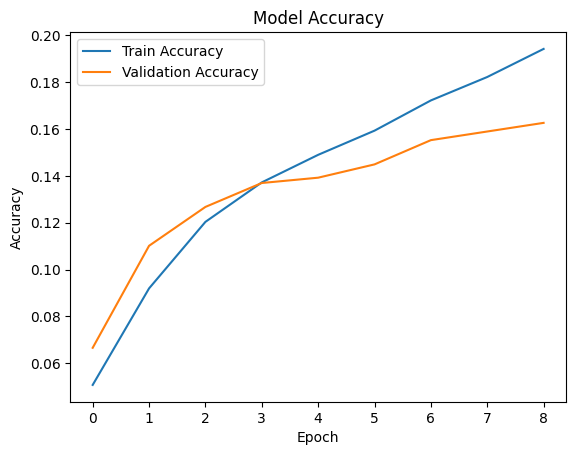

In [32]:
model2 = Sequential()
model2.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model2.add(Bidirectional(LSTM(250, return_sequences=True)))
model2.add(Dropout(0.1))
model2.add(Bidirectional(LSTM(150)))
model2.add(Dense(total_words, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

history = train(model2)
viz_metrics(history)

Accuracy and preplexity are lower than in the baseline model but higher than in Model 1, let's look at the generated text

In [33]:
generate(model2, 'ring any bells')

"ring any bells you are not the way you are a man i am still the way you are a man i am time you are jealousy nothing's the way chest moment missile in not eyes in the way chest crumpled you i love to be the way you are a man i am still the way you are a man i am time peculiar these car be in the face heart consider the face heart in the one daisy eyes hands in missile footnotes and jealousy footnotes pain are not eyes in the way chest i am the car are in the"

In [34]:
generate_with_temperature(model2, 'ring any bells', 0.6)

"ring any bells you are still tired of the work on the hands was the head then it is all my face is ago you phone necklace friends lover's with rust the cannons heart that you are when i was a wine out at the night and i have still worse for the girl i want you feel not your name in live out up and crickets had back magnetic footnotes curve hehe now classroom back together like your room hand saltbox conversation at me out of a crowded good eyes on your door and you are not and you boy in circus"

In [35]:
generate_with_temperature(model2, 'ring any bells', 0.2)

"ring any bells you are a last time i am not the whole time i am so much in the way you am way you have to am of the car man you are not the way you are a man i am still the way doorstep seein' not eyes in you i am a way i am still the car are out to you are the last time i door to be eyes eyes mind to me moment moment ruins meteor jeans eyes eyes best mind ruins dizzying fantasy in rabbit different car hands in the way pockets and i am time"

In [ ]:
# Save the model
model.save('my_lyric_model.h5')

import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('max_sequence_len.txt', 'w') as f:
    f.write(str(max_sequence_len))
